# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

# **Problem Statement**

Create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.  

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

**The project is an extended application of** [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper](https://arxiv.org/abs/1502.03044). 

The dataset is taken from the [Kaggle website](https://www.kaggle.com/adityajn105/flickr8k) and it consists of sentence-based image descriptions having a list of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events of the image.

# Solution Pipeline for Capstone Project
There are four major stages in this solution as described below: <br><br>
1) **Dataset creation**

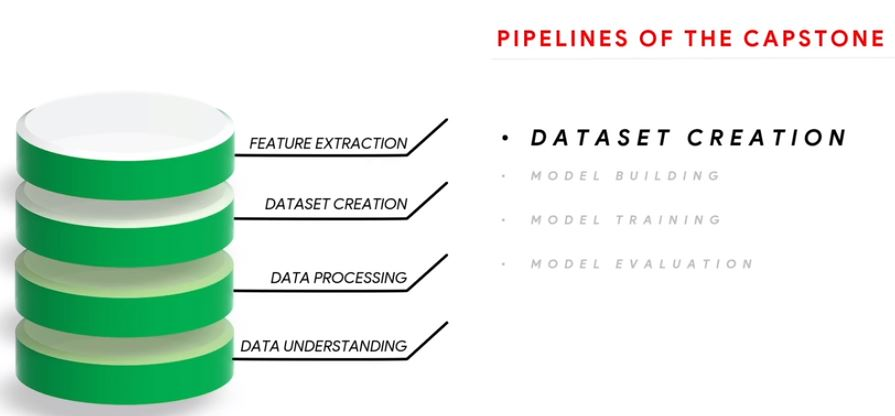


2. **Model Building**

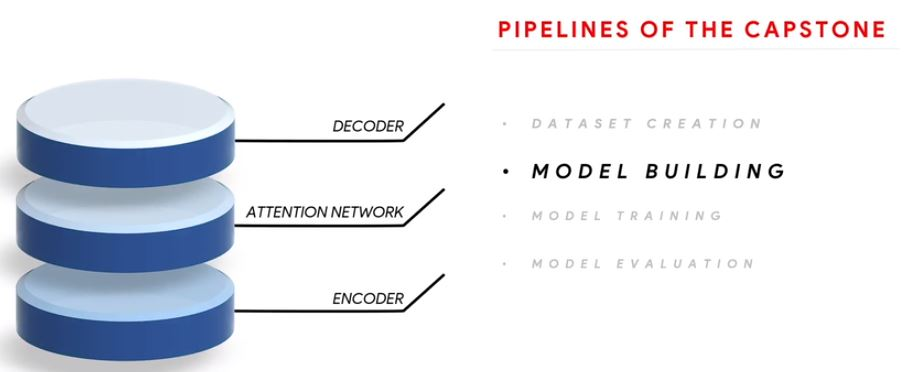

3. **Model Training**

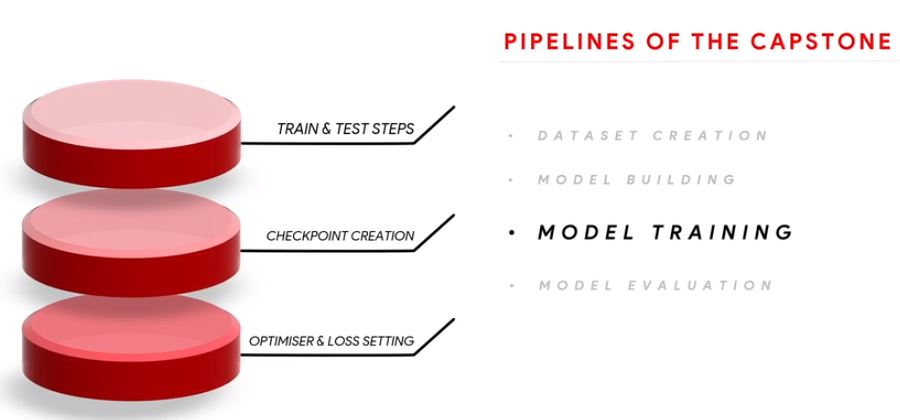

4. **Model Evaluation**

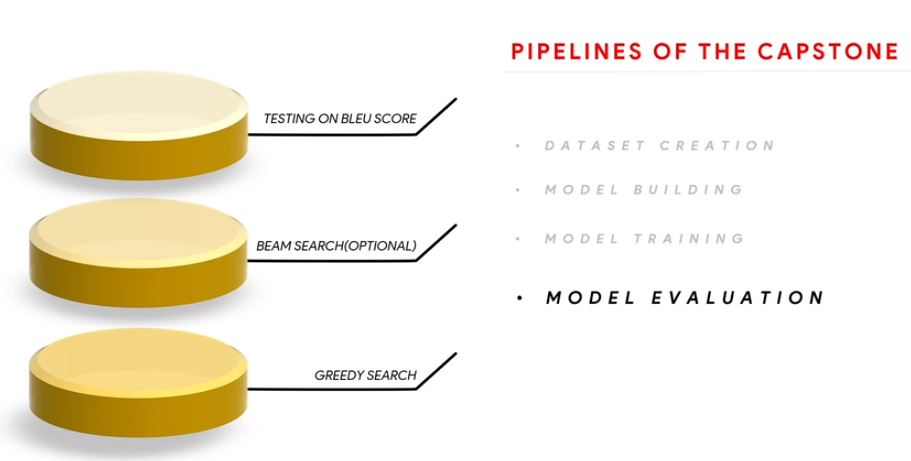

# Solution Architecture

![Solution_Architecture.JPG](attachment:Solution_Architecture.JPG")
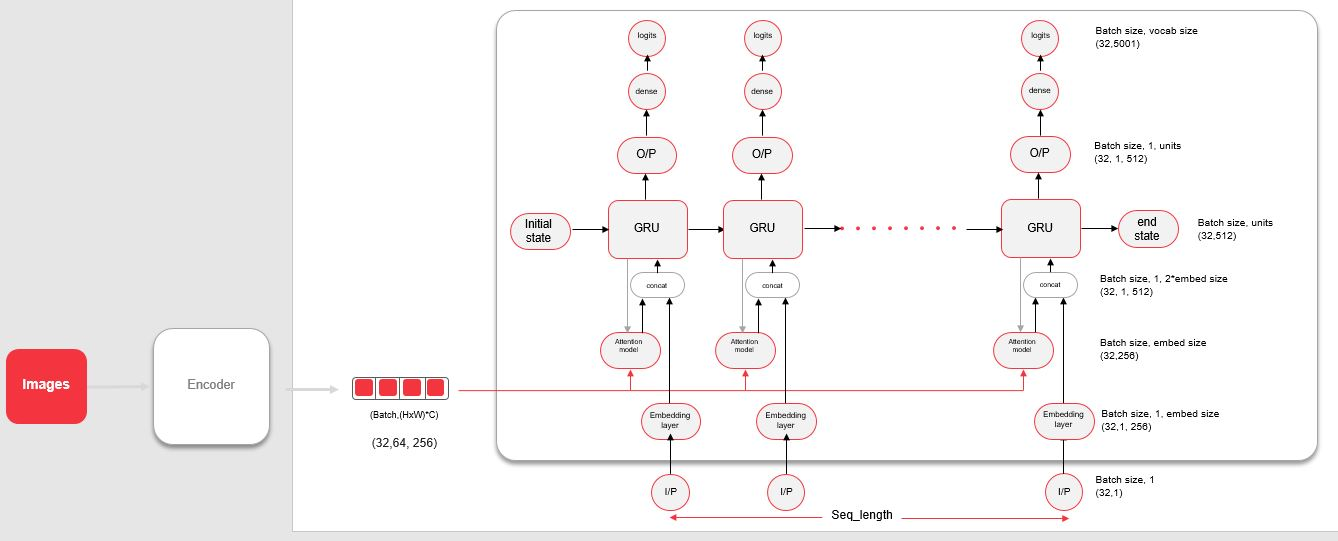

# Libraries Installation

In [1]:
!pip install -q tqdm

In [2]:
! pip install google.cloud.texttospeech

  Using cached https://files.pythonhosted.org/packages/17/0b/3bd642a859da81c15e5bf946077458a8601b3b6190365ca8cd184a17af6b/google_cloud_texttospeech-2.3.0-py2.py3-none-any.whl


In [3]:
# Used Google Colaboratory to develop model since nimblebox was not working (libraries upgrade issues)
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/Jatin/Upgrad/Eye_for_blind_capstone_project/"

data  Eye+for+blind+Starter+code_v1.ipynb  Images


# Import Libraries

In [5]:
#Import all the required libraries

import numpy as np
import pandas as pd
import glob
import cv2
import re
import string
import collections
import random
import time
from collections import Counter
import os
from sklearn.model_selection import train_test_split
from google.cloud import texttospeech

from nltk.tokenize.util import xml_unescape
from nltk.tokenize import word_tokenize

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from PIL import Image

import matplotlib.pyplot as plt

from tqdm import tqdm

# Needed imports
import shutil                                                                                                                                                 
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [6]:
basepath = '/content/drive/My Drive/Jatin/Upgrad/Eye_for_blind_capstone_project/'
text_file = basepath + '/data/captions.txt'
images= basepath + '/Images/'

In [7]:
#Import the dataset and read the image into a seperate variable
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [8]:
#Extract path from read images
pathList = all_imgs[0].split("/")
pathList = pathList[0:len(pathList)-1]
extracted_filepath = '/'.join(pathList)
extracted_filepath = extracted_filepath + '/'
extracted_filepath

'/content/drive/My Drive/Jatin/Upgrad/Eye_for_blind_capstone_project//Images/'

In [9]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    text = pd.read_csv(filename, delimiter = ",")    
    return text

doc = load_doc(text_file)
print(doc[:10])

                       image                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...
5  1001773457_577c3a7d70.jpg         A black dog and a spotted dog are fighting
6  1001773457_577c3a7d70.jpg  A black dog and a tri-colored dog playing with...
7  1001773457_577c3a7d70.jpg  A black dog and a white dog with brown spots a...
8  1001773457_577c3a7d70.jpg  Two dogs of different breeds looking at each o...
9  1001773457_577c3a7d70.jpg    Two dogs on pavement moving toward each other .


In [10]:
# Function to get Image and caption given the index
def getImages_Captions(index):
    image = all_imgs[index]
    image_read = cv2.imread(image)  
    path = image.split(sep="/")
    imageText = list(doc[doc["image"]==path[-1]]["caption"])
    return image_read, imageText

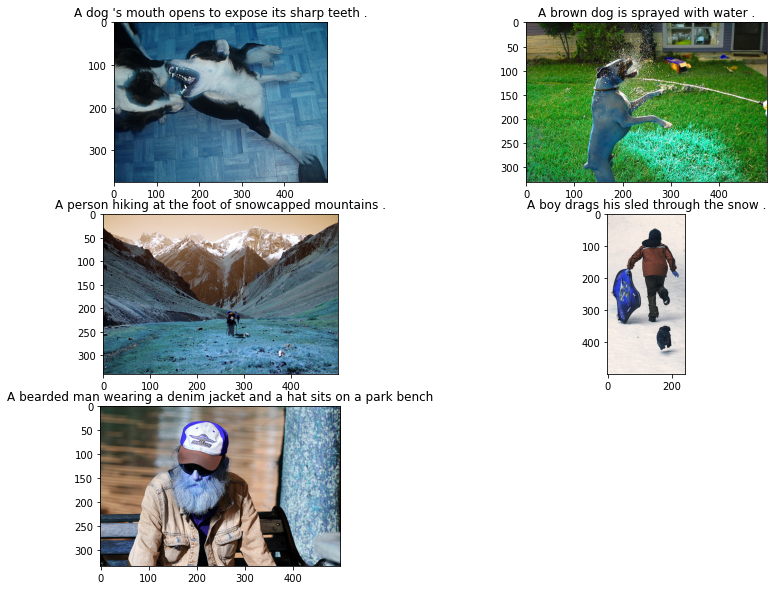

In [11]:
#Visualise both the images & text present in the dataset

plt.figure(figsize=(14,10))
plt.subplot(321)
image_read1, caption1  = getImages_Captions(0)
plt.imshow(image_read1)
plt.title(caption1[0])

plt.subplot(322)
image_read2, caption2  = getImages_Captions(10)
plt.imshow(image_read2)
plt.title(caption2[0])

plt.subplot(323)
image_read3, caption3  = getImages_Captions(20)
plt.imshow(image_read3)
plt.title(caption3[0])

plt.subplot(324)
image_read4, caption4  = getImages_Captions(30)
plt.imshow(image_read4)
plt.title(caption4[0])

plt.subplot(325)
image_read5, caption5  = getImages_Captions(40)
plt.imshow(image_read5)
plt.title(caption5[0])
plt.show()

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [12]:
df = pd.DataFrame(doc).reset_index().drop("index", axis=1)
df["path"] = extracted_filepath + df["image"]
df

,image,caption,path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,/content/drive/My Drive/Jatin/Upgrad/Eye_for_b...


In [13]:
#method to create tokens from sentences
def createTokens(sentences):
    
    allWords = []
    for word in sentences:
        word_lower = word.strip('.,?!"\'').lower().strip()
        allWords.append(word_lower)

    finalText = ' '.join(allWords)
    return finalText

In [14]:
#Create the vocabulary & the counter for the captions
sentences = list(df["caption"])
finalText = createTokens(sentences)
finalText_tokens= finalText.split()

val_count=Counter(finalText_tokens)
val_count

Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 2914,
         'stree

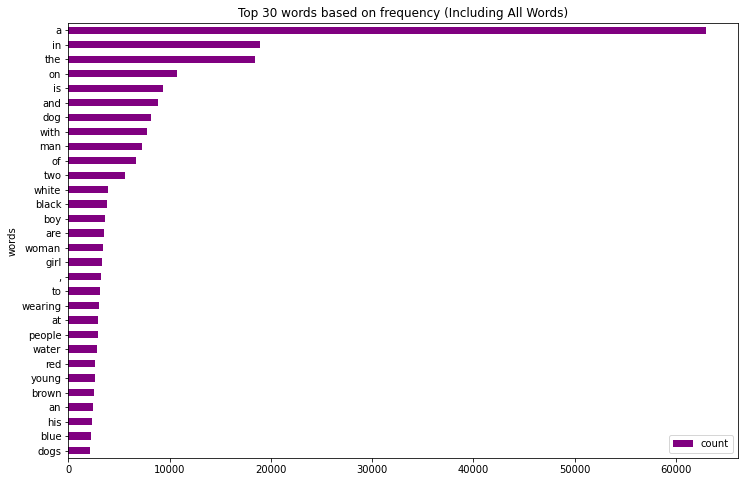

In [15]:
#Visualise the top 30 occuring words in the captions
top30_occuring_words = pd.DataFrame(val_count.most_common(30),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(12, 8))
# Plot horizontal bar graph
top30_occuring_words.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Top 30 words based on frequency (Including All Words)")
plt.show()

In [16]:
#Create a list which contains all the captions
annotations = sentences

#add the <start> & <end> token to all those captions as well
df['caption'] = ["<start> "] + df['caption'].astype(str).apply(str.strip).apply(xml_unescape) + [" <end>"]

#Create a list which contains all the path to the images
all_img_path=list(df['path'])

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions for ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [17]:
# create the tokenizer
top_words = 5000
tokenizer = Tokenizer(num_words=top_words,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~',
    lower=True, split=' ', char_level=False, oov_token="<unk>")

text = list(df["caption"])
tokenizer.fit_on_texts(text) 

In [18]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

sequences = tokenizer.texts_to_sequences(text)
captions = tokenizer.sequences_to_texts(sequences)

print(captions[8:10])
print(sequences[8:10])

['<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>']
[[3, 14, 32, 13, 742, 2654, 90, 23, 138, 83, 7, 6, 152, 4], [3, 14, 32, 7, 728, 806, 322, 138, 83, 4]]


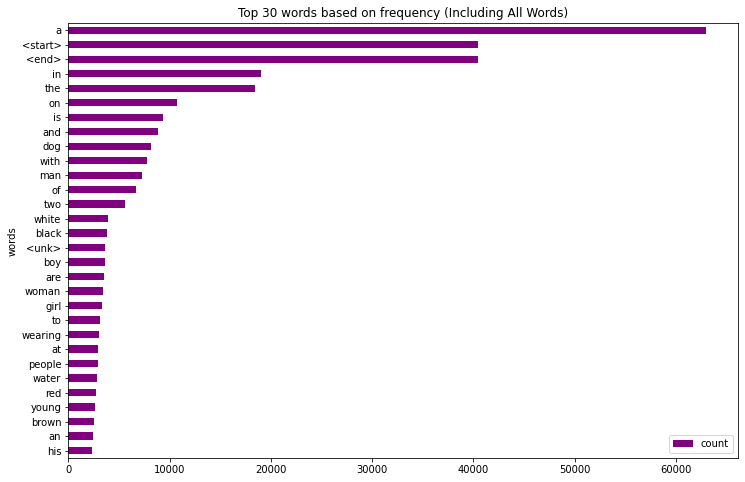

In [19]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
finalText = createTokens(captions)
finalText_tokens= finalText.split()
val_count=Counter(finalText_tokens)

#Visualise the top 30 occuring words in the captions
top30_occuring_words = pd.DataFrame(val_count.most_common(30),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(12, 8))
# Plot horizontal bar graph
top30_occuring_words.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")
ax.set_title("Top 30 words based on frequency (Including All Words)")
plt.show()

In [20]:
# Pad each vector to the max_length of the captions ^ store it to a variable

# Find the maximum length from all captions in list
def calc_max_length(captions):
    max_len_caption = max([len(x) for x in captions])
    return max_len_caption

max_caption_len = calc_max_length(sequences)

cap_vector= pad_sequences(sequences, maxlen=max_caption_len, padding="post")

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [21]:
#write your code here

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [23]:
# write your code to extract features from each image in the dataset

# Get unique images
encode_train = sorted(set(list(df["path"])))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)



In [24]:
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

'\nfor img, path in image_dataset:\n    batch_features = image_features_extract_model(img)\n    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))\n    \n    for bf, p in zip(batch_features, path):\n        path_of_feature = p.numpy().decode("utf-8")\n        np.save(path_of_feature, bf.numpy())\n'

## Create the train & test data 

Create the train-test spliit using 80-20 ratio & random state = 42

1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. 

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [25]:
#write your code here
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(list(df["path"]), cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
#random.shuffle(img_keys)

img_name_train_keys, img_name_val_keys = train_test_split(img_keys, test_size=0.2, random_state=42)

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

## DataSet creation

In [27]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [28]:
# prefetch data to buffer
def generate_dataset(img_name, caption, BUFFER_SIZE, BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [29]:
BATCH_SIZE = 512

train_dataset = generate_dataset(img_name_train, cap_train, 1000, BATCH_SIZE)
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(512, 64, 2048)
(512, 39)


In [30]:
test_dataset = generate_dataset(img_name_val, cap_val, 1000, BATCH_SIZE)

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [31]:
embedding_dim = 256 
units = 512
vocab_size = top_words +1
BUFFER_SIZE = 1000
lr = 0.001
train_num_steps = len(img_name_train) // BATCH_SIZE
test_num_steps = len(img_name_val) // BATCH_SIZE
attention_features_shape = 64

### Encoder

In [32]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features = self.dense(features)
        features =  tf.nn.relu(features)
        return features

In [33]:
encoder=Encoder(embedding_dim)

### Attention model

In [34]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # build your score funciton to shape: (batch_size, 8*8, units)
        score = self.V(attention_hidden_layer)

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights =  tf.nn.softmax(score, axis=1)

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector =  attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

### Decoder

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units

        #iniitalise your Attention model with units
        self.attention = Attention_model(self.units) 

        #build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) 
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform', dropout=0.4, recurrent_dropout=0.4)
        #build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.4)
        #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)

        # embed your input to shape: (batch_size, 1, embedding_dim)
        x =  self.embed(x)

        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        x =  tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(x, training=True)
        x = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2])) 

        x = self.dropout(x)

        # shape : (batch_size * max_length, vocab_size)
        x = self.d2(x) 

        return x,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [36]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [37]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (512, 64, 256)
Predcitions shape from Decoder: (512, 5001)
Attention weights shape from Decoder: (512, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [38]:
#define the optimizer
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr, momentum=0.6)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#define your loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [39]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [40]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [42]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
          #Pass features through the decoder
          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

          # Calculate loss
          loss += loss_function(target[:,i], predictions)

          # Teacher enforcing - pass decoder input from target
          dec_input = tf.expand_dims(target[:,i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, total_loss

In [43]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    features = encoder(img_tensor)
    for i in range(1,target.shape[1]):
        #Pass features through the decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Calculate loss
        loss += loss_function(target[:,i], predictions)

        # pass decoder input from predictions
        predicted_id = tf.argmax(predictions, axis=1)
    
        dec_input = tf.expand_dims(predicted_id, 1)

    total_loss = (loss / int(target.shape[1]))
        
    return loss, total_loss

In [44]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [45]:
loss_plot = []
test_loss_plot = []
EPOCHS = 25

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    #    if batch % 100 == 0:
    #      average_batch_loss = batch_loss.numpy()/int(target.shape[1])
    #      print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for {} epoch {} mins\n'.format(epoch+1,(time.time() - start)/60))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  4%|▍         | 1/25 [1:03:18<25:19:23, 3798.47s/it]

For epoch: 1, the train loss is 1.698, & test loss is 1.698
Time taken for 1 epoch 63.30477549235026 mins

Test loss has been reduced from 100.000 to 1.698


  8%|▊         | 2/25 [1:05:45<17:16:08, 2702.99s/it]

For epoch: 2, the train loss is 1.380, & test loss is 2.022
Time taken for 2 epoch 2.448138213157654 mins



 12%|█▏        | 3/25 [1:08:11<11:49:49, 1935.91s/it]

For epoch: 3, the train loss is 1.191, & test loss is 2.148
Time taken for 3 epoch 2.433858633041382 mins



 16%|█▌        | 4/25 [1:10:38<8:09:42, 1399.16s/it] 

For epoch: 4, the train loss is 1.095, & test loss is 2.085
Time taken for 4 epoch 2.445387363433838 mins



 20%|██        | 5/25 [1:13:04<5:41:06, 1023.30s/it]

For epoch: 5, the train loss is 1.034, & test loss is 2.117
Time taken for 5 epoch 2.4382885495821633 mins



 24%|██▍       | 6/25 [1:15:30<4:00:45, 760.27s/it] 

For epoch: 6, the train loss is 0.990, & test loss is 2.126
Time taken for 6 epoch 2.4422394156455995 mins



 28%|██▊       | 7/25 [1:17:57<2:52:48, 576.02s/it]

For epoch: 7, the train loss is 0.955, & test loss is 2.131
Time taken for 7 epoch 2.4351210912068684 mins



 32%|███▏      | 8/25 [1:20:23<2:06:41, 447.12s/it]

For epoch: 8, the train loss is 0.927, & test loss is 2.086
Time taken for 8 epoch 2.4390188177426655 mins



 36%|███▌      | 9/25 [1:22:47<1:35:00, 356.28s/it]

For epoch: 9, the train loss is 0.903, & test loss is 2.120
Time taken for 9 epoch 2.404892710844676 mins



 40%|████      | 10/25 [1:25:13<1:13:17, 293.19s/it]

For epoch: 10, the train loss is 0.882, & test loss is 2.124
Time taken for 10 epoch 2.4328935901323954 mins



 44%|████▍     | 11/25 [1:27:39<58:03, 248.84s/it]  

For epoch: 11, the train loss is 0.864, & test loss is 2.090
Time taken for 11 epoch 2.4225235263506573 mins



 48%|████▊     | 12/25 [1:30:04<47:11, 217.83s/it]

For epoch: 12, the train loss is 0.847, & test loss is 2.107
Time taken for 12 epoch 2.424766500790914 mins



 52%|█████▏    | 13/25 [1:32:28<39:08, 195.68s/it]

For epoch: 13, the train loss is 0.830, & test loss is 2.110
Time taken for 13 epoch 2.39983419974645 mins



 56%|█████▌    | 14/25 [1:34:53<33:04, 180.44s/it]

For epoch: 14, the train loss is 0.815, & test loss is 2.184
Time taken for 14 epoch 2.4147806962331138 mins



 60%|██████    | 15/25 [1:37:18<28:18, 169.87s/it]

For epoch: 15, the train loss is 0.802, & test loss is 2.144
Time taken for 15 epoch 2.4200244148572287 mins



 64%|██████▍   | 16/25 [1:39:44<24:23, 162.66s/it]

For epoch: 16, the train loss is 0.789, & test loss is 2.193
Time taken for 16 epoch 2.430222996075948 mins



 68%|██████▊   | 17/25 [1:42:10<21:01, 157.69s/it]

For epoch: 17, the train loss is 0.774, & test loss is 2.179
Time taken for 17 epoch 2.4348502198855084 mins



 72%|███████▏  | 18/25 [1:44:36<17:59, 154.18s/it]

For epoch: 18, the train loss is 0.763, & test loss is 2.187
Time taken for 18 epoch 2.4333439548810323 mins



 76%|███████▌  | 19/25 [1:47:01<15:08, 151.48s/it]

For epoch: 19, the train loss is 0.752, & test loss is 2.172
Time taken for 19 epoch 2.419421398639679 mins



 80%|████████  | 20/25 [1:49:27<12:29, 149.81s/it]

For epoch: 20, the train loss is 0.740, & test loss is 2.207
Time taken for 20 epoch 2.4314738949139914 mins



 84%|████████▍ | 21/25 [1:51:55<09:56, 149.12s/it]

For epoch: 21, the train loss is 0.729, & test loss is 2.231
Time taken for 21 epoch 2.458421246210734 mins



 88%|████████▊ | 22/25 [1:54:20<07:24, 148.11s/it]

For epoch: 22, the train loss is 0.722, & test loss is 2.207
Time taken for 22 epoch 2.429498330752055 mins



 92%|█████████▏| 23/25 [1:56:47<04:55, 147.66s/it]

For epoch: 23, the train loss is 0.714, & test loss is 2.257
Time taken for 23 epoch 2.4434606631596885 mins



 96%|█████████▌| 24/25 [1:59:12<02:26, 147.00s/it]

For epoch: 24, the train loss is 0.703, & test loss is 2.244
Time taken for 24 epoch 2.4239705642064413 mins



100%|██████████| 25/25 [2:01:38<00:00, 291.94s/it]

For epoch: 25, the train loss is 0.696, & test loss is 2.276
Time taken for 25 epoch 2.4256531516710917 mins



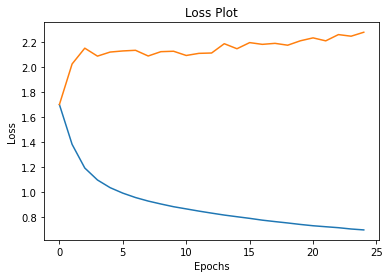

In [46]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [47]:
def evaluate(image):
    attention_plot = np.zeros((max_caption_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_caption_len):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        dec_input = tf.expand_dims([predicted_id], 0)

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [48]:
#def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
#    return final_caption

In [49]:
def plot_attmap(result, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(result)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(result[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [50]:
from nltk.translate.bleu_score import sentence_bleu

In [51]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU-1 score: 44.44444444444444
BELU-2 score: 23.570226039551585
BELU-3 score: 23.852346274405658
BELU-4 score: 22.277411682906493
Real Caption: two girls playing in a game of softball
Prediction Caption: a catcher in a baseball uniform is playing softball


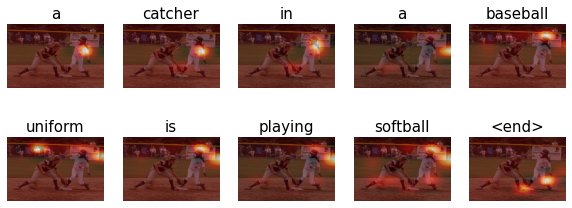

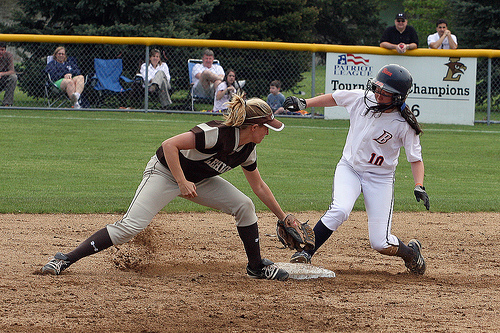

In [75]:
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4

rid = np.random.randint(0, len(img_name_val))
test_image = img_name_val[rid]
#test_image = '/content/drive/My Drive/Colab Notebooks/Upgrad/Eye_for_blind_capstone_project/data/Images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0),smoothing_function=smoothie)
score3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0),smoothing_function=smoothie)
score4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)

print(f"BELU-1 score: {score1*100}")
print(f"BELU-2 score: {score2*100}")
print(f"BELU-3 score: {score3*100}")
print(f"BELU-4 score: {score4*100}")


print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)

plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [53]:
#captions=beam_evaluate(test_image)
#print(captions)

## Google Text to Speech API

Text to Speech API needs authentication to execute request. Authentication details are stored in a json file which should be present in the execution environment. Google uses "GOOGLE_APPLICATION_CREDENTIALS" variable for that.

In [58]:
# Upload authentication json file to root
# Copy authentication json file from root to specific folder
shutil.copy('/jatin-capstone-project-b69d442a088a.json','/opt/google/user/')  # here shutil is using hard coded names

'/opt/google/user/jatin-capstone-project-b69d442a088a.json'

In [76]:
# Setup google application credential variable in lcoal environment
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/opt/google/user/jatin-capstone-project-b69d442a088a.json"

# Google text to speech API. Saves audio file in local system.
def text_to_wav(voice_name, text):
    language_code = "-".join(voice_name.split("-")[:2])
    text_input = texttospeech.SynthesisInput(text=text)
    voice_params = texttospeech.VoiceSelectionParams(
        language_code=language_code, name=voice_name
    )
    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.LINEAR16
    )

    client = texttospeech.TextToSpeechClient()
    response = client.synthesize_speech(
        input=text_input, voice=voice_params, audio_config=audio_config
    )

    filename = f"{language_code}.wav"
    with open(filename, "wb") as out:
        out.write(response.audio_content)
        print(f'Audio content written to "{filename}"')

In [77]:
text_to_wav("en-AU-Wavenet-A", pred_caption)
data = wavfile.read("en-AU.wav")
# Separete the object elements
framerate = data[0]
sounddata = data[1]

# Generate a player for mono sound, autoplay to play it without manual trigger.
Audio(sounddata,rate=framerate,autoplay=True)

Audio content written to "en-AU.wav"
